# Caso: Modelo de Predicción de Venta de Seguros a Clientes

Puede descargar los datos de: https://www.kaggle.com/competitions/playground-series-s4e7/data

## Instalar las librerías

In [1]:
!pip install ydata-profiling
!pip install kds
!pip install lightgbm
!pip install xgboost

## 1. Carga de Módulos

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from ydata_profiling import ProfileReport

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, classification_report, roc_auc_score, f1_score, auc, roc_curve
)
import kds

In [2]:
# Leemos la data de desarrollo de modelos
df = pd.read_csv('../data/raw/train.csv')

In [3]:
# Crear insurances.csv (1 millón de registros)
train_sample = df.groupby('Response', group_keys=False).apply(
    lambda x: x.sample(n=int(1_000_000 * len(x)/len(df)), random_state=42)
)
# Guardar train
train_sample.to_csv('../data/raw/insurances.csv', index=False)

# Crear insurances_new.csv (500k registros, misma distribución, sin solapamiento)
df_remaining = df.drop(train_sample.index)
valid_sample = df_remaining.groupby('Response', group_keys=False).apply(
    lambda x: x.sample(n=int(500_000 * len(x)/len(df_remaining)), random_state=42)
)
# Guardar valid
valid_sample.to_csv('../data/raw/insurances_new.csv', index=False)

## 2. Lectura Inicial de base de datos

### 2.1 Carga de datos

In [4]:
# Leemos la data de desarrollo de modelos
df = pd.read_csv('../data/raw/insurances.csv')

In [5]:
# Vemos la dimensionalidad
df.shape

(999999, 12)

In [6]:
# Visualizacion Global de los datos
df.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  9312666    Male   45                1          3.0                   1   
1  7451099  Female   25                1         29.0                   1   
2  2954187  Female   48                1         28.0                   0   
3  5438487    Male   48                1         28.0                   1   
4   469689    Male   22                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year             No         40255.0                  26.0      158   
1    < 1 Year             No         37886.0                 152.0      105   
2    1-2 Year            Yes         45362.0                  26.0      149   
3    1-2 Year             No         35124.0                  26.0       96   
4    < 1 Year             No         25775.0                 152.0      271   

   Response  
0         0  
1         0  
2         0  
3         0  
4         0

### 2.2. Buenas prácticas

In [7]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    999999 non-null  int64  
 1   Gender                999999 non-null  object 
 2   Age                   999999 non-null  int64  
 3   Driving_License       999999 non-null  int64  
 4   Region_Code           999999 non-null  float64
 5   Previously_Insured    999999 non-null  int64  
 6   Vehicle_Age           999999 non-null  object 
 7   Vehicle_Damage        999999 non-null  object 
 8   Annual_Premium        999999 non-null  float64
 9   Policy_Sales_Channel  999999 non-null  float64
 10  Vintage               999999 non-null  int64  
 11  Response              999999 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 91.6+ MB


# 3. AED

## 3.1. Completitud de los datos

In [9]:
# Revisamos los valores nulos o missings
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 3.2. Análisis Univariado

In [10]:
profile = ProfileReport(df, title="Reporte Pandas Profiling")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.11it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Eliminamos columna Id
df = df.drop(columns=['id'])

In [12]:
# Verificamos duplicados
df.duplicated().sum()

0

In [13]:
## Para variables Cualitativas
def plot_cat(feature):
  sns.countplot(data=df, x=feature)
  ax=sns.countplot(data=df, x=feature, palette='tab10')

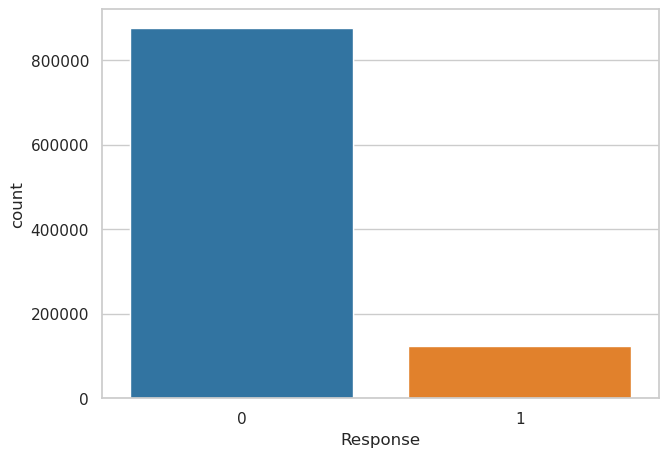

In [14]:
plot_cat('Response')

In [15]:
## Calculando la proporción del Target
df.Response.value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

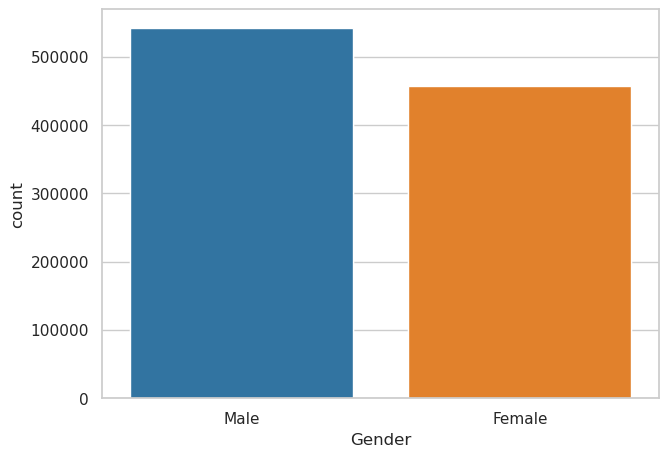

In [16]:
plot_cat('Gender')

In [17]:
df.groupby('Gender').Response.value_counts(normalize=True).unstack(fill_value=0)

Response         0         1
Gender                      
Female    0.896996  0.103004
Male      0.860117  0.139883

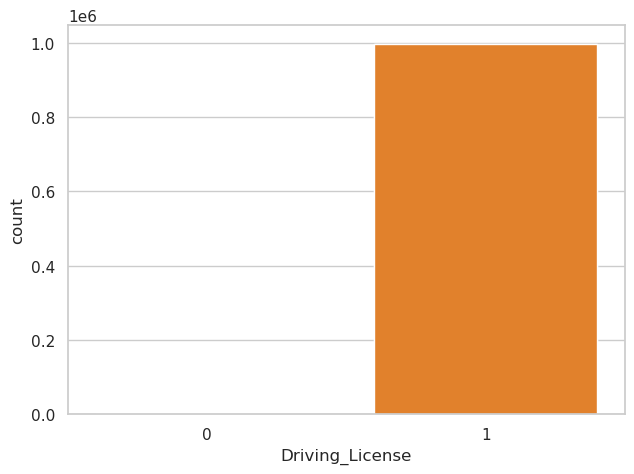

In [18]:
plot_cat('Driving_License')

In [19]:
df.groupby('Driving_License').Response.value_counts(normalize=True).unstack(fill_value=0)

Response                0         1
Driving_License                    
0                0.944246  0.055754
1                0.876871  0.123129

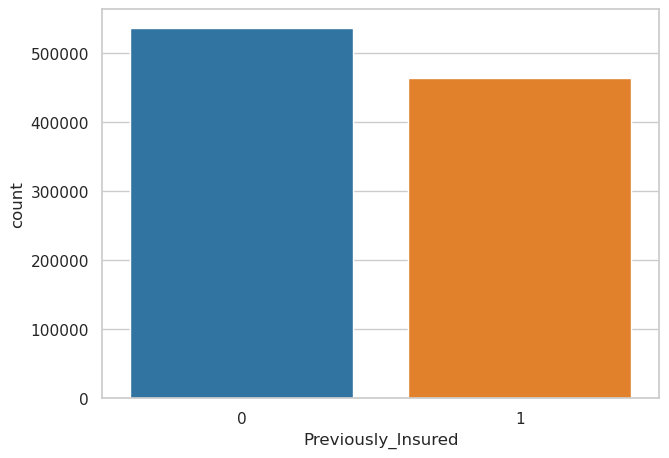

In [20]:
plot_cat('Previously_Insured')

In [21]:
df.groupby('Previously_Insured').Response.value_counts(normalize=True).unstack(fill_value=0)

Response                   0         1
Previously_Insured                    
0                   0.771322  0.228678
1                   0.999254  0.000746

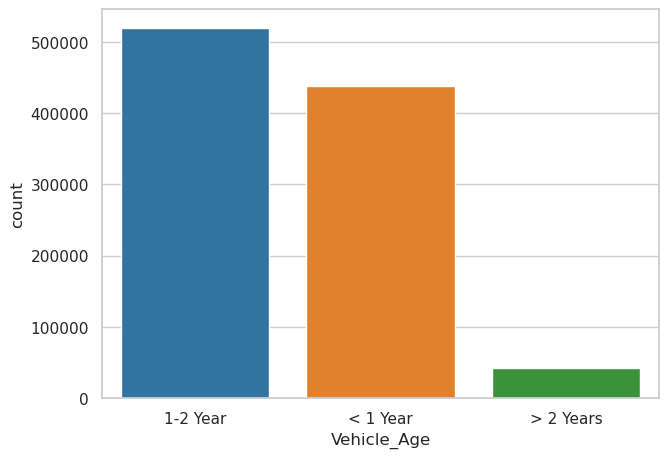

In [22]:
plot_cat('Vehicle_Age')

In [23]:
df.groupby('Vehicle_Age').Response.value_counts(normalize=True).unstack(fill_value=0)

Response            0         1
Vehicle_Age                    
1-2 Year     0.822093  0.177907
< 1 Year     0.958629  0.041371
> 2 Years    0.702831  0.297169

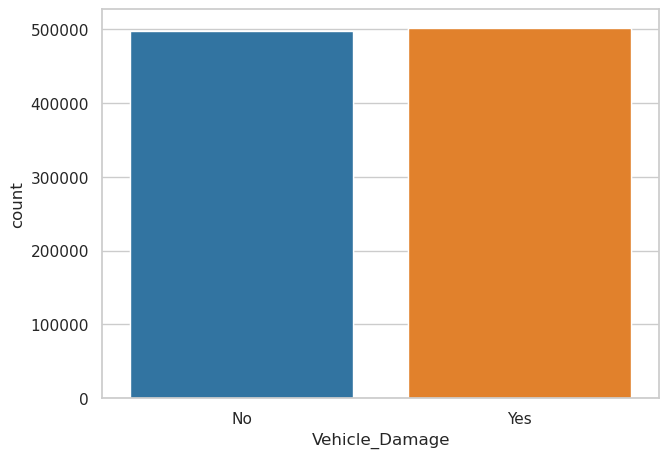

In [24]:
plot_cat('Vehicle_Damage')

In [25]:
df.groupby('Vehicle_Damage').Response.value_counts(normalize=True).unstack(fill_value=0)

Response               0         1
Vehicle_Damage                    
No              0.995763  0.004237
Yes             0.759183  0.240817

In [26]:
## Para variables cuantitativas
def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=feature,ax=axes[0])
    sns.distplot(a=df[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)

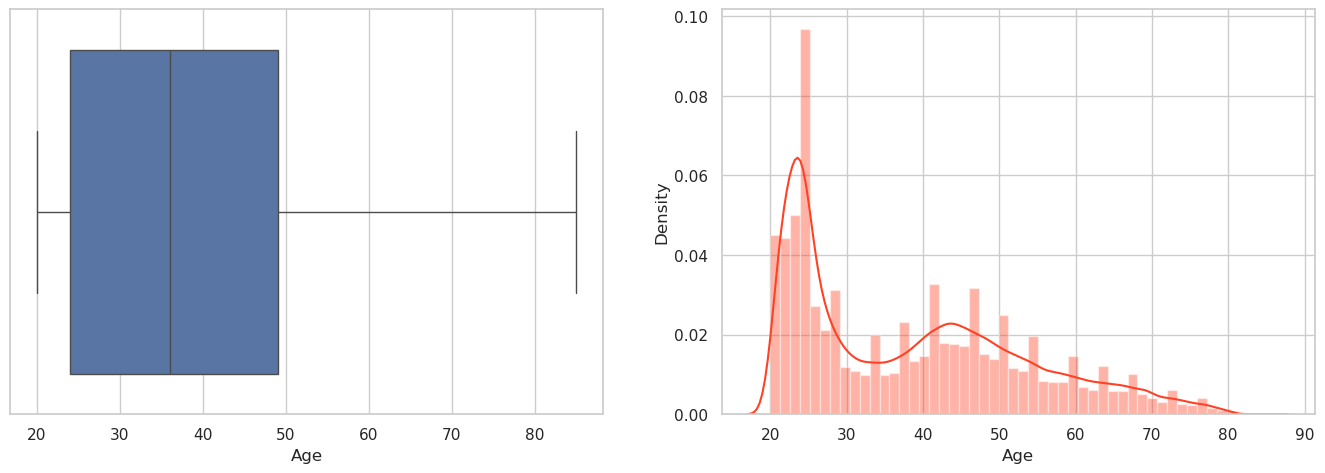

In [27]:
plot_num('Age')

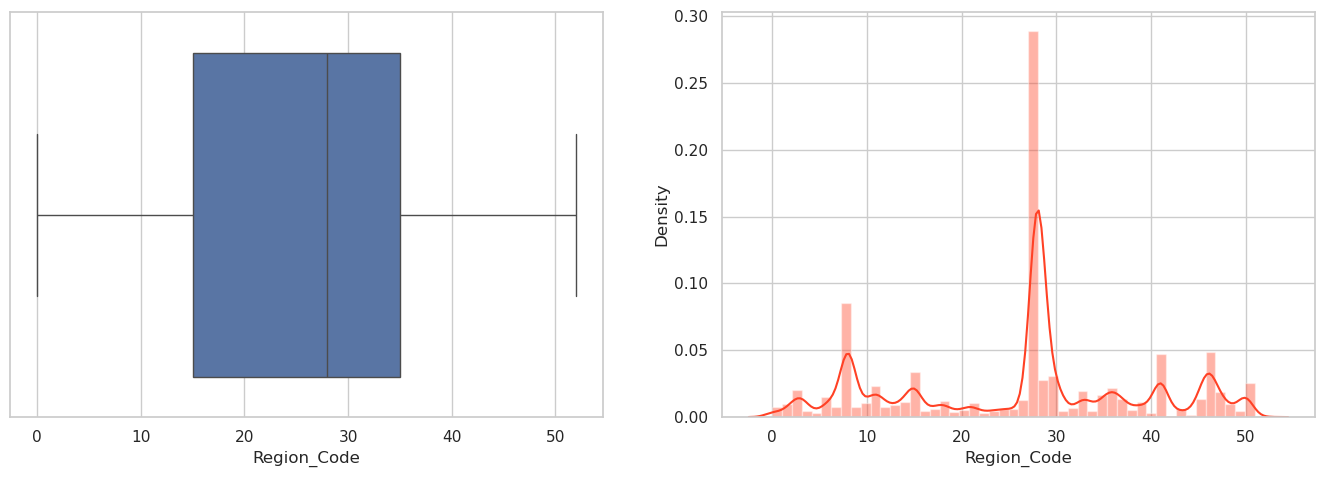

In [28]:
plot_num('Region_Code')

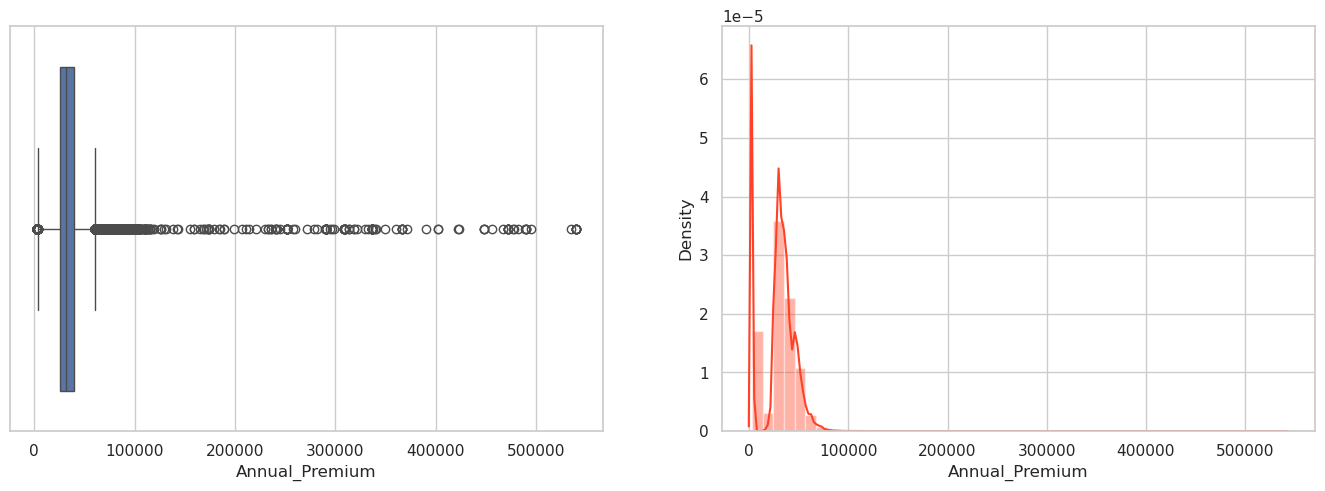

In [29]:
plot_num('Annual_Premium')

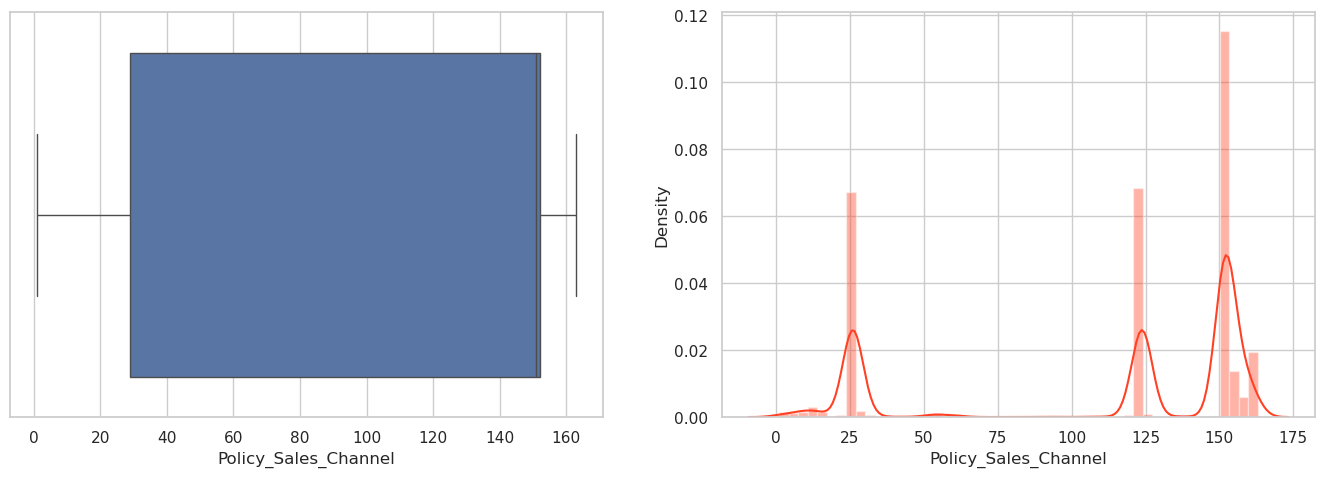

In [30]:
plot_num('Policy_Sales_Channel')

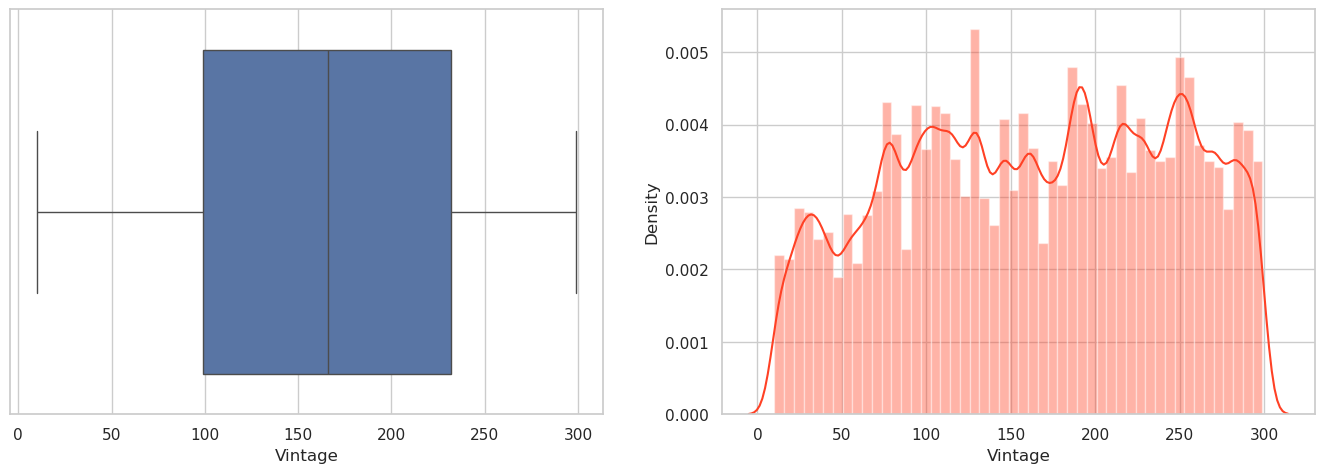

In [31]:
plot_num('Vintage')

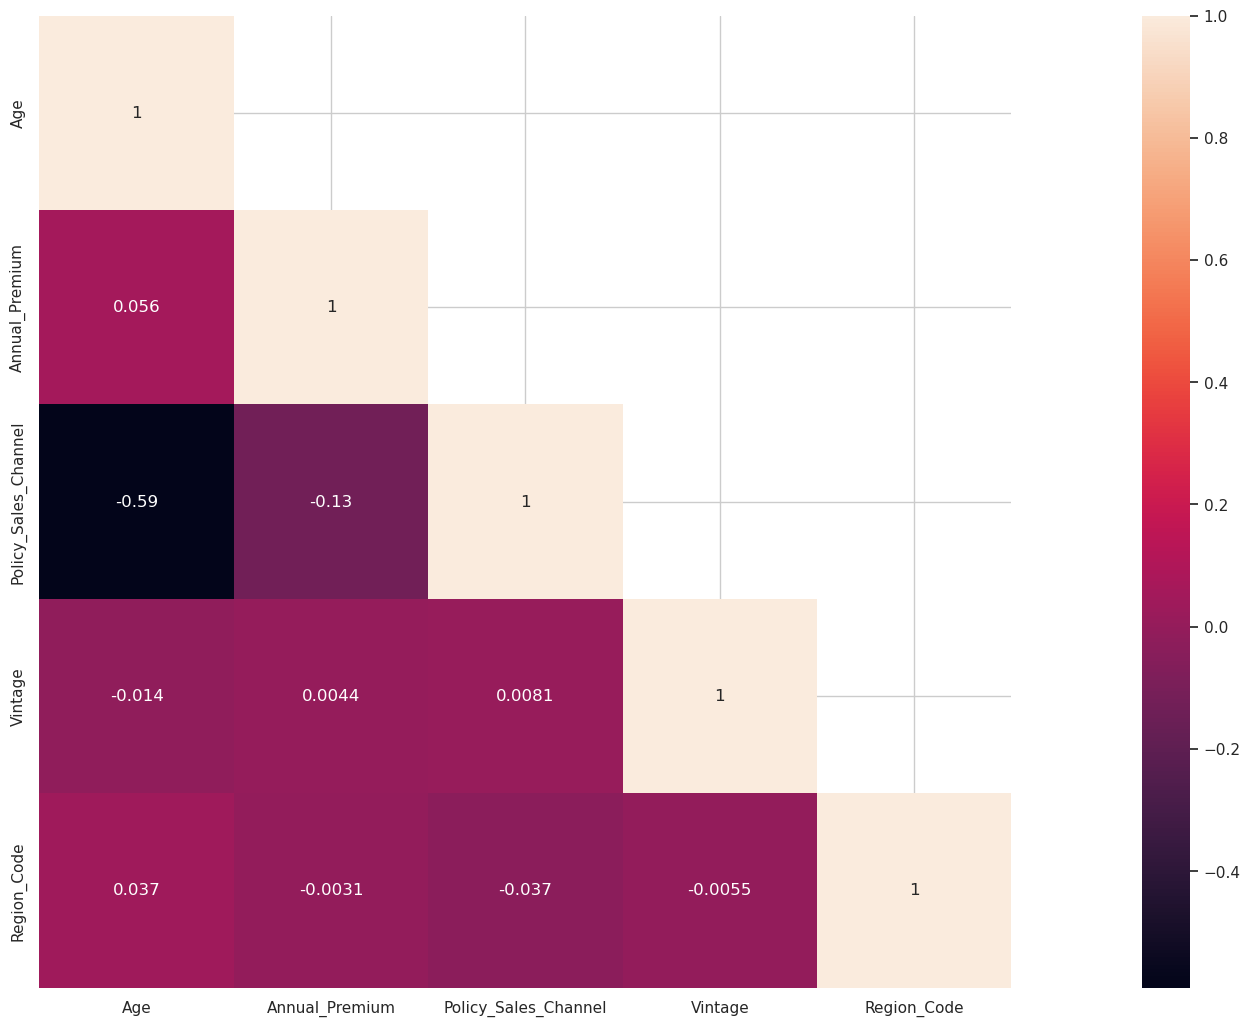

In [32]:
# Matriz de corelaciones
cor_mat = df[['Age', 'Annual_Premium','Policy_Sales_Channel', 'Vintage', 'Region_Code']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.show()

Observamos que no existen correlaciones significativas entre los tres grupos de variables

## 3.3. Recodificación y transformación de los datos

In [33]:
# Recodificamos variables 
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1}).astype("int32")
df["Region_Code"] = df["Region_Code"].astype(int)
df["Vehicle_Age"] = df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype("int32")
df["Vehicle_Damage"] = df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int32")
df["Annual_Premium"] = df["Annual_Premium"].astype(int)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].astype(int)

# 4. Ingeniería y Selección de Variables

## 4.1. Ingeniería de variables

In [34]:
# Transformamos variables
df["Previously_Insured_Annual_Premium"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Annual_Premium"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Age"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Age"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Damage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Damage"].astype(str)
)[0]

df["Previously_Insured_Vintage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vintage"].astype(str)
)[0]

In [35]:
df.to_csv("../data/processed/insurances.csv")

## 4.2. Ingeniería de variables

In [36]:
# Seleccion por LightGBM
import lightgbm as lgb
train_data = lgb.Dataset(df.drop("Response", axis=1), label=df["Response"])

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "num_leaves": 64,
    "learning_rate": 0.05,
    "n_jobs": -1
}

lgbm_model = lgb.train(params, train_data, num_boost_round=500)
importances = lgbm_model.feature_importance()

[LightGBM] [Info] Number of positive: 122997, number of negative: 877002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 999999, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964349
[LightGBM] [Info] Start training from score -1.964349


In [37]:
drivers = df.drop("Response", axis=1).columns

TablaImportancia = pd.DataFrame({
    "Driver": drivers,
    "Importancia": importances
})

TablaImportancia["Importancia_pct"] = (
    TablaImportancia["Importancia"] / TablaImportancia["Importancia"].sum()
) * 100

ImportanciaVariables = (
    TablaImportancia
    .sort_values("Importancia_pct", ascending=False)
    .reset_index(drop=True)
)

ImportanciaVariables.head(20)

Driver  Importancia  Importancia_pct
0                             Vintage         5502        17.466667
1          Previously_Insured_Vintage         4687        14.879365
2                      Annual_Premium         4533        14.390476
3   Previously_Insured_Annual_Premium         4469        14.187302
4                                 Age         3940        12.507937
5                         Region_Code         3539        11.234921
6                Policy_Sales_Channel         2675         8.492063
7   Previously_Insured_Vehicle_Damage          470         1.492063
8                              Gender          465         1.476190
9      Previously_Insured_Vehicle_Age          457         1.450794
10                        Vehicle_Age          371         1.177778
11                     Vehicle_Damage          238         0.755556
12                 Previously_Insured          103         0.326984
13                    Driving_License           51         0.161905

In [38]:
# Regresion Logistica
import statsmodels.api as sm
logit_model = sm.Logit(df.Response, df.drop(['Response'], axis=1))
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.272070
         Iterations 11
                                  Results: Logit
Model:                    Logit                 Method:                MLE        
Dependent Variable:       Response              Pseudo R-squared:      0.270      
Date:                     2025-11-15 22:58      AIC:                   544168.0732
No. Observations:         999999                BIC:                   544333.4903
Df Model:                 13                    Log-Likelihood:        -2.7207e+05
Df Residuals:             999985                LL-Null:               -3.7285e+05
Converged:                1.0000                LLR p-value:           0.0000     
No. Iterations:           11.0000               Scale:                 1.0000     
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

<Axes: >

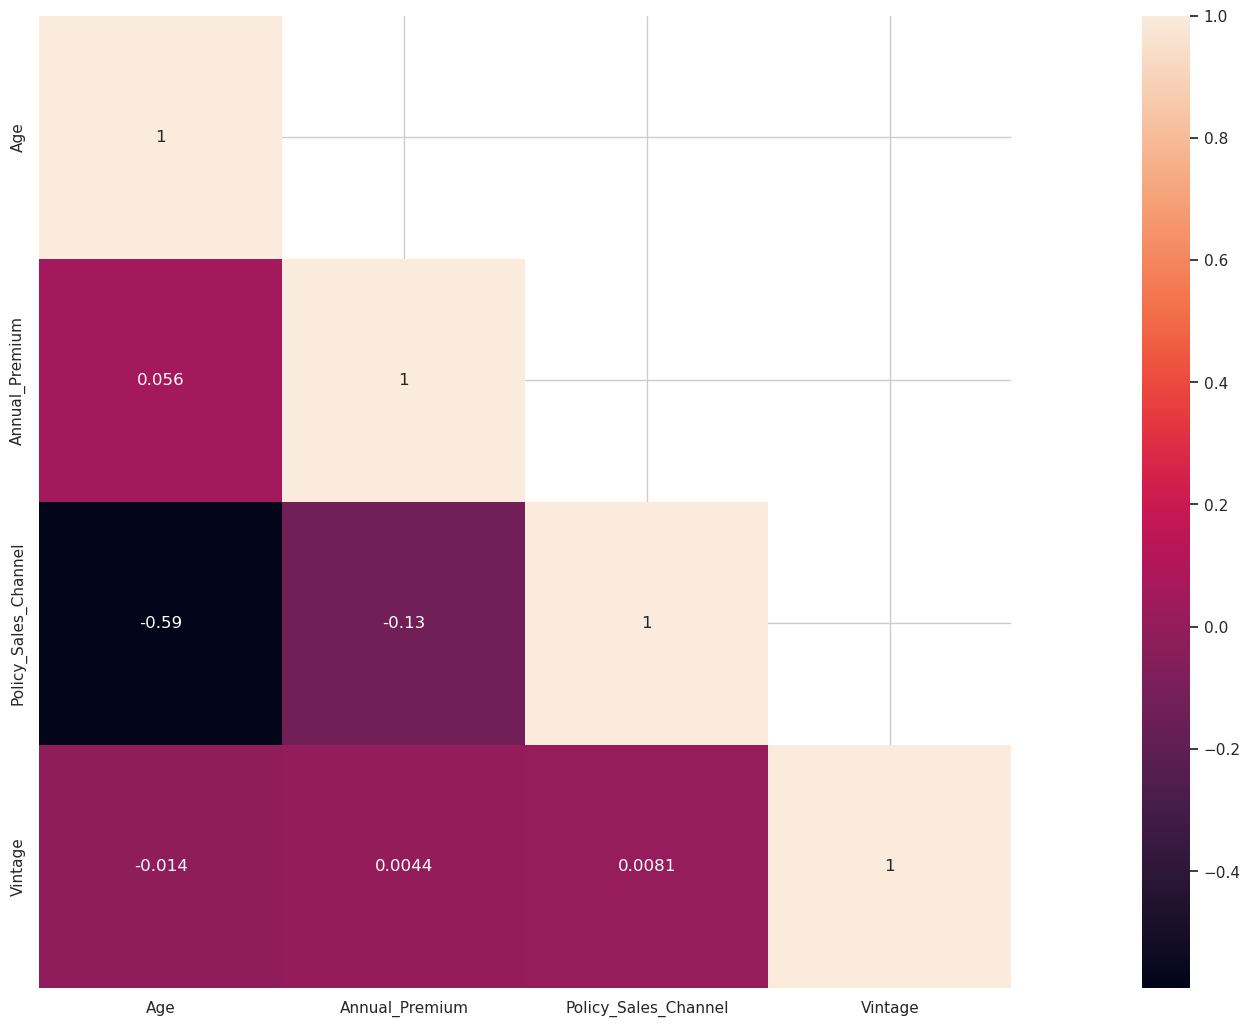

In [39]:
## Matriz de corelaciones numéricas
cor_mat = df[["Age","Annual_Premium","Policy_Sales_Channel","Vintage"]].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [40]:
# Análisis VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[["Gender","Age","Driving_License","Region_Code","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Age","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             variable        VIF
0                              Gender   1.903958
1                                 Age  21.446395
2                     Driving_License  89.172762
3                         Region_Code   5.108377
4                  Previously_Insured  17.992169
5                         Vehicle_Age   6.252523
6                      Vehicle_Damage   7.742918
7                      Annual_Premium   5.897512
8                Policy_Sales_Channel   8.591746
9                             Vintage   5.208470
10  Previously_Insured_Annual_Premium   2.492453
11     Previously_Insured_Vehicle_Age  14.649256
12  Previously_Insured_Vehicle_Damage   4.231893
13         Previously_Insured_Vintage   3.663343


In [41]:
# Se elimina Driving_License y Previously_Insured_Vehicle_Age por VIF, baja significacia y baja importancia
X = df[["Gender","Age","Region_Code","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             variable        VIF
0                              Gender   1.863110
1                                 Age  16.979392
2                         Region_Code   4.852011
3                  Previously_Insured   7.718959
4                         Vehicle_Age   6.239938
5                      Vehicle_Damage   5.917848
6                      Annual_Premium   5.525534
7                Policy_Sales_Channel   6.196319
8                             Vintage   4.892215
9   Previously_Insured_Annual_Premium   2.491652
10  Previously_Insured_Vehicle_Damage   3.386344
11         Previously_Insured_Vintage   3.496694


In [42]:
# Regresion Logistica sin Driving_License y Previously_Insured_Vehicle_Age
logit_model=sm.Logit(df.Response,df[["Gender","Age","Region_Code","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.274355
         Iterations 11
                                  Results: Logit
Model:                     Logit                 Method:                MLE        
Dependent Variable:        Response              Pseudo R-squared:      0.264      
Date:                      2025-11-15 22:59      AIC:                   548734.1059
No. Observations:          999999                BIC:                   548875.8920
Df Model:                  11                    Log-Likelihood:        -2.7436e+05
Df Residuals:              999987                LL-Null:               -3.7285e+05
Converged:                 1.0000                LLR p-value:           0.0000     
No. Iterations:            11.0000               Scale:                 1.0000     
-----------------------------------------------------------------------------------
                                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------

In [43]:
# Regresion Logistica sin Region_Code por no se significativo
logit_model=sm.Logit(df.Response,df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.274355
         Iterations 11
                                  Results: Logit
Model:                     Logit                 Method:                MLE        
Dependent Variable:        Response              Pseudo R-squared:      0.264      
Date:                      2025-11-15 22:59      AIC:                   548732.4102
No. Observations:          999999                BIC:                   548862.3808
Df Model:                  10                    Log-Likelihood:        -2.7436e+05
Df Residuals:              999988                LL-Null:               -3.7285e+05
Converged:                 1.0000                LLR p-value:           0.0000     
No. Iterations:            11.0000               Scale:                 1.0000     
-----------------------------------------------------------------------------------
                                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------

In [44]:
# Se elimina Region_Code por no se significativo
X = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             variable        VIF
0                              Gender   1.859397
1                                 Age  16.700125
2                  Previously_Insured   7.457630
3                         Vehicle_Age   6.239931
4                      Vehicle_Damage   5.776804
5                      Annual_Premium   5.502861
6                Policy_Sales_Channel   6.084260
7                             Vintage   4.874158
8   Previously_Insured_Annual_Premium   2.491448
9   Previously_Insured_Vehicle_Damage   3.325625
10         Previously_Insured_Vintage   3.485869


# 5. Modelamiento de Datos o Creación del Algoritmo de ML

## 5.1. Partición Muestral

In [45]:
data = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage", "Response"]].sample(frac=0.9, random_state=1000)
data_unseen = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage", "Response"]].drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (899999, 12)
Unseen Data For Predictions: (100000, 12)


In [47]:
# Creación de los datos de train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Response'],axis=1),
                                                   data.Response,
                                                   test_size=0.333,
                                                   random_state=12345) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(600299, 11) (600299,)
(299700, 11) (299700,)


In [48]:
X_train.head()

Gender  Age  Previously_Insured  Vehicle_Age  Vehicle_Damage  \
126011       0   47                   0            1               1   
3875         1   27                   1            0               0   
864703       1   41                   0            1               1   
163720       1   41                   1            1               0   
664506       1   21                   1            0               0   

        Annual_Premium  Policy_Sales_Channel  Vintage  \
126011           43720                    26      186   
3875             27218                   152       31   
864703            2630                   124      213   
163720           51520                   124      143   
664506           29184                   152      119   

        Previously_Insured_Annual_Premium  Previously_Insured_Vehicle_Damage  \
126011                              30863                                  1   
3875                                19031                                  0   
864703                                 13                                  1   
163720                              10878                                  0   
664506                              18817                                  0   

        Previously_Insured_Vintage  
126011                          49  
3875                           418  
864703                         468  
163720                          98  
664506                         496

## 5.2. Algoritmos de Machine Learning

### Regresión Logística Binaria

In [49]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [50]:
lr.fit(X_train,y_train) # Entrenamiento!

LogisticRegression()

In [51]:
y_pred_train=lr.predict(X_train) # Prediccion sobre train
y_pred_test = lr.predict(X_test) # Prediccion sobre test

In [52]:
## Metricas de validación
def calc_metrics(y_train, y_pred_train, y_test, y_pred_test, show_train_report=False):
    # === MATRIZ DE CONFUSIÓN TRAIN ===
    print("=== Matriz de Confusión (Train) ===")
    cm_train = confusion_matrix(y_train, y_pred_train)
    print(cm_train)

    # === MATRIZ DE CONFUSIÓN TEST ===
    print("\n=== Matriz de Confusión (Test) ===")
    cm_test = confusion_matrix(y_test, y_pred_test)
    print(cm_test)

    # === CLASSIFICATION REPORT ===
    print("\n=== Classification Report (Test) ===")
    print(classification_report(y_test, y_pred_test))

    if show_train_report:
        print("\n=== Classification Report (Train) ===")
        print(classification_report(y_train, y_pred_train))

In [53]:
calc_metrics(y_train, y_pred_train, y_test, y_pred_test)

=== Matriz de Confusión (Train) ===
[[526809      1]
 [ 73489      0]]

=== Matriz de Confusión (Test) ===
[[262640      0]
 [ 37060      0]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    262640
           1       0.00      0.00      0.00     37060

    accuracy                           0.88    299700
   macro avg       0.44      0.50      0.47    299700
weighted avg       0.77      0.88      0.82    299700



In [54]:
ind = pd.DataFrame(columns = ['Modelo', 'F1Score'])

f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['LogReg'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo  F1Score
0  LogReg      0.0

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1     0.245     0.476     0.284   29970.0    6412.0       23558.0   
1       2     0.197     0.245     0.221   29970.0    5856.0       24114.0   
2       3     0.129     0.197     0.163   29970.0    5150.0       24820.0   
3       4     0.108     0.129     0.116   29970.0    3838.0       26132.0   
4       5     0.097     0.108     0.102   29970.0    3164.0       26806.0   
5       6     0.090     0.097     0.094   29970.0    2888.0       27082.0   
6       7     0.083     0.090     0.086   29970.0    2655.0       27315.0   
7       8     0.077     0.083     0.080   29970.0    2409.0       27561.0   
8       9     0.069     0.077     0.073   29970.0    2362.0       27608.0   
9      10     0.001     0.069     0.062   29970.0    2326.0       27644.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         3706.0         29970     21.395   29970.0    6412.0         29970   
1         3706.0          7090     19.540   59940.0   12268.0         37060   
2         3706.0             0     17.184   89910.0   17418.0         37060   
3         3706.0             0     12.806  119880.0   21256.0         37060   
4         3706.0             0     10.557  149850.0   24420.0         37060   
5         3706.0             0      9.636  179820.0   27308.0         37060   
6         3706.0             0      8.859  209790.0   29963.0         37060   
7         3706.0             0      8.038  239760.0   32372.0         37060   
8         3706.0             0      7.881  269730.0   34734.0         37060   
9         3706.0             0      7.761  299700.0   37060.0         37060   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       23558.0          10.0        17.302            80.869   
1       47672.0          20.0        33.103           100.000   
2       72492.0          30.0        46.999           100.000   
3       98624.0          40.0        57.356           100.000   
4      125430.0          50.0        65.893           100.000   
5      152512.0          60.0        73.686           100.000   
6      179827.0          70.0        80.850           100.000   
7      207388.0          80.0        87.350           100.000   
8      234996.0          90.0        93.724           100.000   
9      262640.0         100.0       100.000           100.000   

   cum_non_resp_pct      KS   lift  
0             8.970   8.332  1.730  
1            18.151  14.952  1.655  
2            27.601  19.398  1.567  
3            37.551  19.805  1.434  
4            47.757  18.136  1.318  
5            58.069  15.617  1.228  
6            68.469  12.381  1.155  
7            78.963   8.387  1.092  
8            89.475   4.249  1.041  
9           100.000   0.000  1.000

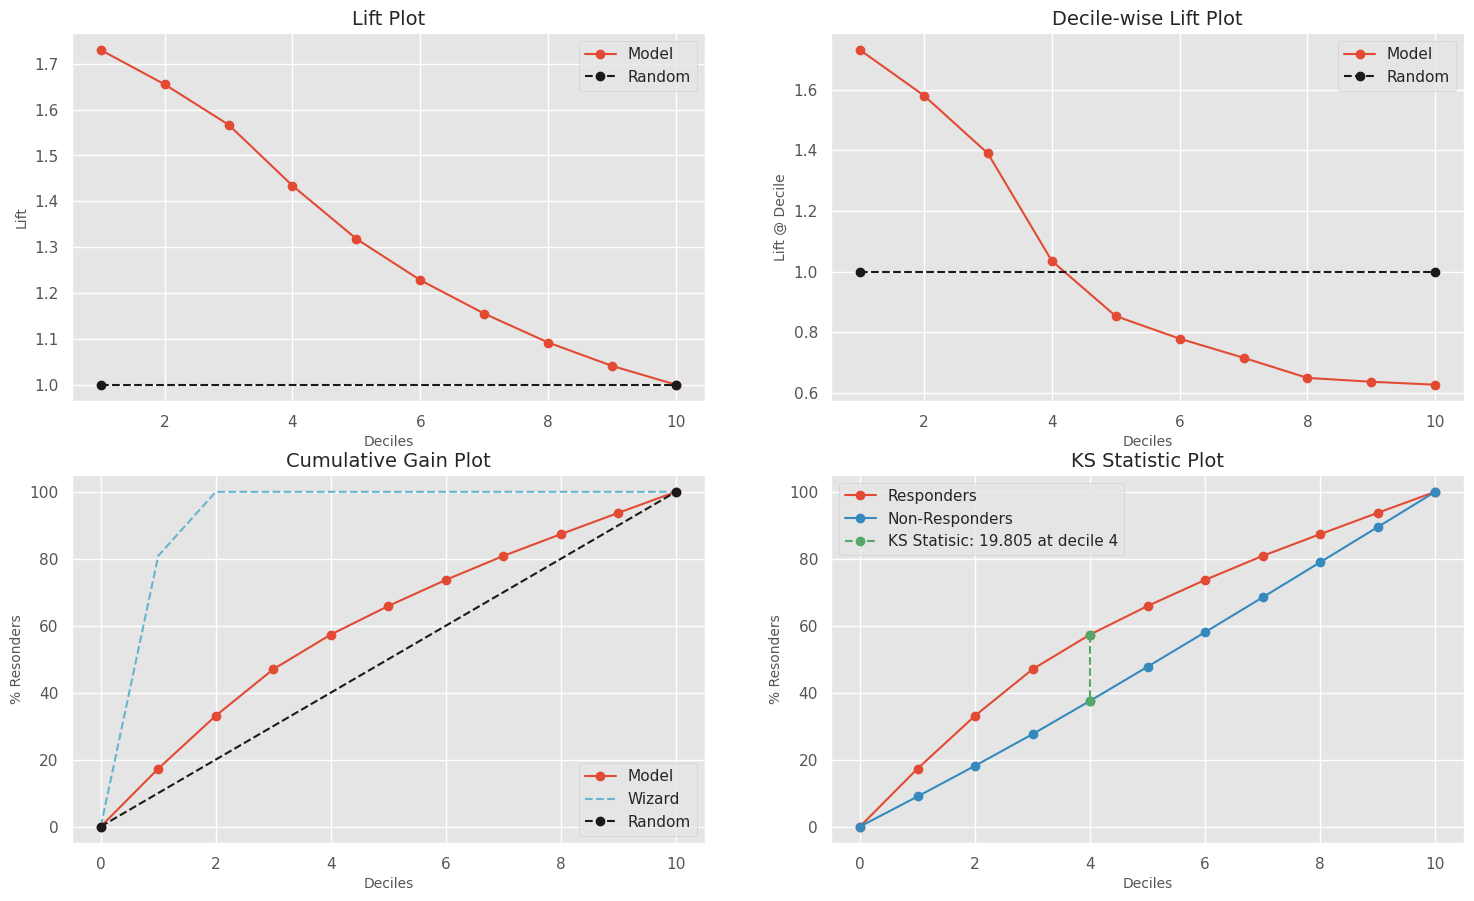

In [55]:
y_prob = lr.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

### Xgboost

In [56]:
import xgboost as xgb
xgb_mod=xgb.XGBClassifier(max_depth=2, n_estimators=50, objective='binary:logistic', seed=0, silent=True, subsample=.8)
xgb_mod.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [57]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=xgb_mod.predict(X_train) # Prediccion sobre train
y_pred_test= xgb_mod.predict(X_test) # Prediccion sobre test

In [58]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

=== Matriz de Confusión (Train) ===
[[526448    362]
 [ 72039   1450]]

=== Matriz de Confusión (Test) ===
[[262467    173]
 [ 36293    767]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    262640
           1       0.82      0.02      0.04     37060

    accuracy                           0.88    299700
   macro avg       0.85      0.51      0.49    299700
weighted avg       0.87      0.88      0.82    299700



In [59]:
f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['XGBoost'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0   LogReg  0.000000
1  XGBoost  0.040368

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1       0.0       1.0     0.031   29970.0    4367.0       25603.0   
1       2       0.0       0.0     0.000   29970.0    3600.0       26370.0   
2       3       0.0       0.0     0.000   29970.0    3676.0       26294.0   
3       4       0.0       0.0     0.000   29970.0    3658.0       26312.0   
4       5       0.0       0.0     0.000   29970.0    3613.0       26357.0   
5       6       0.0       0.0     0.000   29970.0    3667.0       26303.0   
6       7       0.0       0.0     0.000   29970.0    3690.0       26280.0   
7       8       0.0       0.0     0.000   29970.0    3673.0       26297.0   
8       9       0.0       0.0     0.000   29970.0    3650.0       26320.0   
9      10       0.0       0.0     0.000   29970.0    3466.0       26504.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         3706.0         29970     14.571   29970.0    4367.0         29970   
1         3706.0          7090     12.012   59940.0    7967.0         37060   
2         3706.0             0     12.266   89910.0   11643.0         37060   
3         3706.0             0     12.206  119880.0   15301.0         37060   
4         3706.0             0     12.055  149850.0   18914.0         37060   
5         3706.0             0     12.236  179820.0   22581.0         37060   
6         3706.0             0     12.312  209790.0   26271.0         37060   
7         3706.0             0     12.256  239760.0   29944.0         37060   
8         3706.0             0     12.179  269730.0   33594.0         37060   
9         3706.0             0     11.565  299700.0   37060.0         37060   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       25603.0          10.0        11.784            80.869   
1       51973.0          20.0        21.498           100.000   
2       78267.0          30.0        31.417           100.000   
3      104579.0          40.0        41.287           100.000   
4      130936.0          50.0        51.036           100.000   
5      157239.0          60.0        60.931           100.000   
6      183519.0          70.0        70.888           100.000   
7      209816.0          80.0        80.799           100.000   
8      236136.0          90.0        90.648           100.000   
9      262640.0         100.0       100.000           100.000   

   cum_non_resp_pct     KS   lift  
0             9.748  2.036  1.178  
1            19.789  1.709  1.075  
2            29.800  1.617  1.047  
3            39.818  1.469  1.032  
4            49.854  1.182  1.021  
5            59.869  1.062  1.016  
6            69.875  1.013  1.013  
7            79.887  0.912  1.010  
8            89.909  0.739  1.007  
9           100.000  0.000  1.000

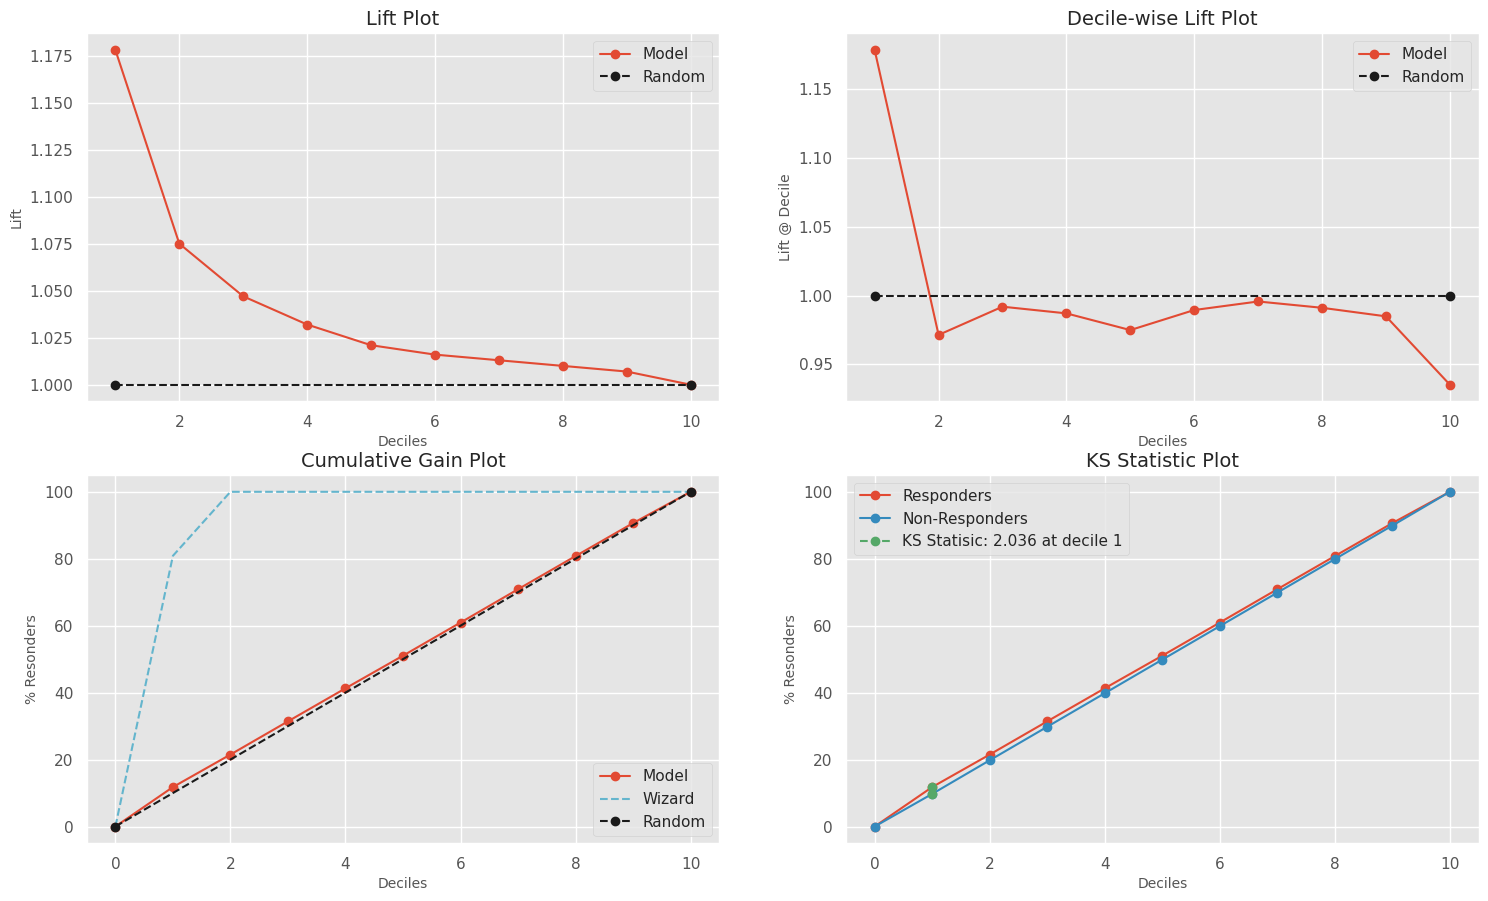

In [60]:
kds.metrics.report(y_test, y_pred_test,plot_style='ggplot')

### Grid Search de Parámetros

In [61]:
# Definimos la funcion de GridSearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [62]:
# Configuramos el subset de parametros a trabajar
cv_params = {'max_depth': [2,3,4],
            'subsample':[0.7,0.8,0.9],
             'n_estimators':[50,100,200]}

In [63]:
# Definimos un clasificador inicial, generalmente sin muchos parametros
xgboost_t=xgb.XGBClassifier().fit(X_train, y_train)

In [64]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM = RandomizedSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5) 

In [65]:
# Buscamos los parametros de acuerdo a nuestro criterio
opGBM=optimized_GBM.fit(X_train, y_train)

In [66]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros 
print(optimized_GBM.best_params_)

{'subsample': 0.9, 'n_estimators': 100, 'max_depth': 4}


In [67]:
# Predecimos con el algoritmo entrenado sobre el test y evaluamos
y_pred_train=opGBM.predict(X_train)
y_pred_test=opGBM.predict(X_test)

In [68]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

=== Matriz de Confusión (Train) ===
[[523160   3650]
 [ 66868   6621]]

=== Matriz de Confusión (Test) ===
[[260655   1985]
 [ 33776   3284]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    262640
           1       0.62      0.09      0.16     37060

    accuracy                           0.88    299700
   macro avg       0.75      0.54      0.55    299700
weighted avg       0.85      0.88      0.84    299700



In [69]:
f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['GridSearch'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0      LogReg  0.000000
1     XGBoost  0.040368
2  GridSearch  0.155165

In [70]:
from sklearn.metrics import precision_recall_curve

y_prob_test = opGBM.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_prob_test)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)

# Índice del mejor F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Mejor threshold:", best_threshold)
print("F1 alcanzado:", best_f1)

Mejor threshold: 0.248621
F1 alcanzado: 0.4868264077689775


In [71]:
y_pred_test_opt = (y_prob_test >= best_threshold).astype(int)
calc_metrics(y_train, y_pred_train, y_test, y_pred_test_opt)

=== Matriz de Confusión (Train) ===
[[523160   3650]
 [ 66868   6621]]

=== Matriz de Confusión (Test) ===
[[217888  44752]
 [ 10739  26321]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.95      0.83      0.89    262640
           1       0.37      0.71      0.49     37060

    accuracy                           0.81    299700
   macro avg       0.66      0.77      0.69    299700
weighted avg       0.88      0.81      0.84    299700



In [72]:
f1score=f1_score(y_test,y_pred_test_opt)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['GridSearchUmbral'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0            LogReg  0.000000
1           XGBoost  0.040368
2        GridSearch  0.155165
3  GridSearchUmbral  0.486826

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1     0.358     0.956     0.444   29970.0   13983.0       15987.0   
1       2     0.276     0.358     0.315   29970.0    9487.0       20483.0   
2       3     0.198     0.276     0.238   29970.0    6846.0       23124.0   
3       4     0.110     0.198     0.153   29970.0    4518.0       25452.0   
4       5     0.028     0.110     0.068   29970.0    1894.0       28076.0   
5       6     0.001     0.028     0.009   29970.0     296.0       29674.0   
6       7     0.000     0.001     0.000   29970.0      19.0       29951.0   
7       8     0.000     0.000     0.000   29970.0       7.0       29963.0   
8       9     0.000     0.000     0.000   29970.0       7.0       29963.0   
9      10     0.000     0.000     0.000   29970.0       3.0       29967.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         3706.0         29970     46.657   29970.0   13983.0         29970   
1         3706.0          7090     31.655   59940.0   23470.0         37060   
2         3706.0             0     22.843   89910.0   30316.0         37060   
3         3706.0             0     15.075  119880.0   34834.0         37060   
4         3706.0             0      6.320  149850.0   36728.0         37060   
5         3706.0             0      0.988  179820.0   37024.0         37060   
6         3706.0             0      0.063  209790.0   37043.0         37060   
7         3706.0             0      0.023  239760.0   37050.0         37060   
8         3706.0             0      0.023  269730.0   37057.0         37060   
9         3706.0             0      0.010  299700.0   37060.0         37060   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       15987.0          10.0        37.731            80.869   
1       36470.0          20.0        63.330           100.000   
2       59594.0          30.0        81.802           100.000   
3       85046.0          40.0        93.994           100.000   
4      113122.0          50.0        99.104           100.000   
5      142796.0          60.0        99.903           100.000   
6      172747.0          70.0        99.954           100.000   
7      202710.0          80.0        99.973           100.000   
8      232673.0          90.0        99.992           100.000   
9      262640.0         100.0       100.000           100.000   

   cum_non_resp_pct      KS   lift  
0             6.087  31.644  3.773  
1            13.886  49.444  3.166  
2            22.690  59.112  2.727  
3            32.381  61.613  2.350  
4            43.071  56.033  1.982  
5            54.369  45.534  1.665  
6            65.773  34.181  1.428  
7            77.182  22.791  1.250  
8            88.590  11.402  1.111  
9           100.000   0.000  1.000

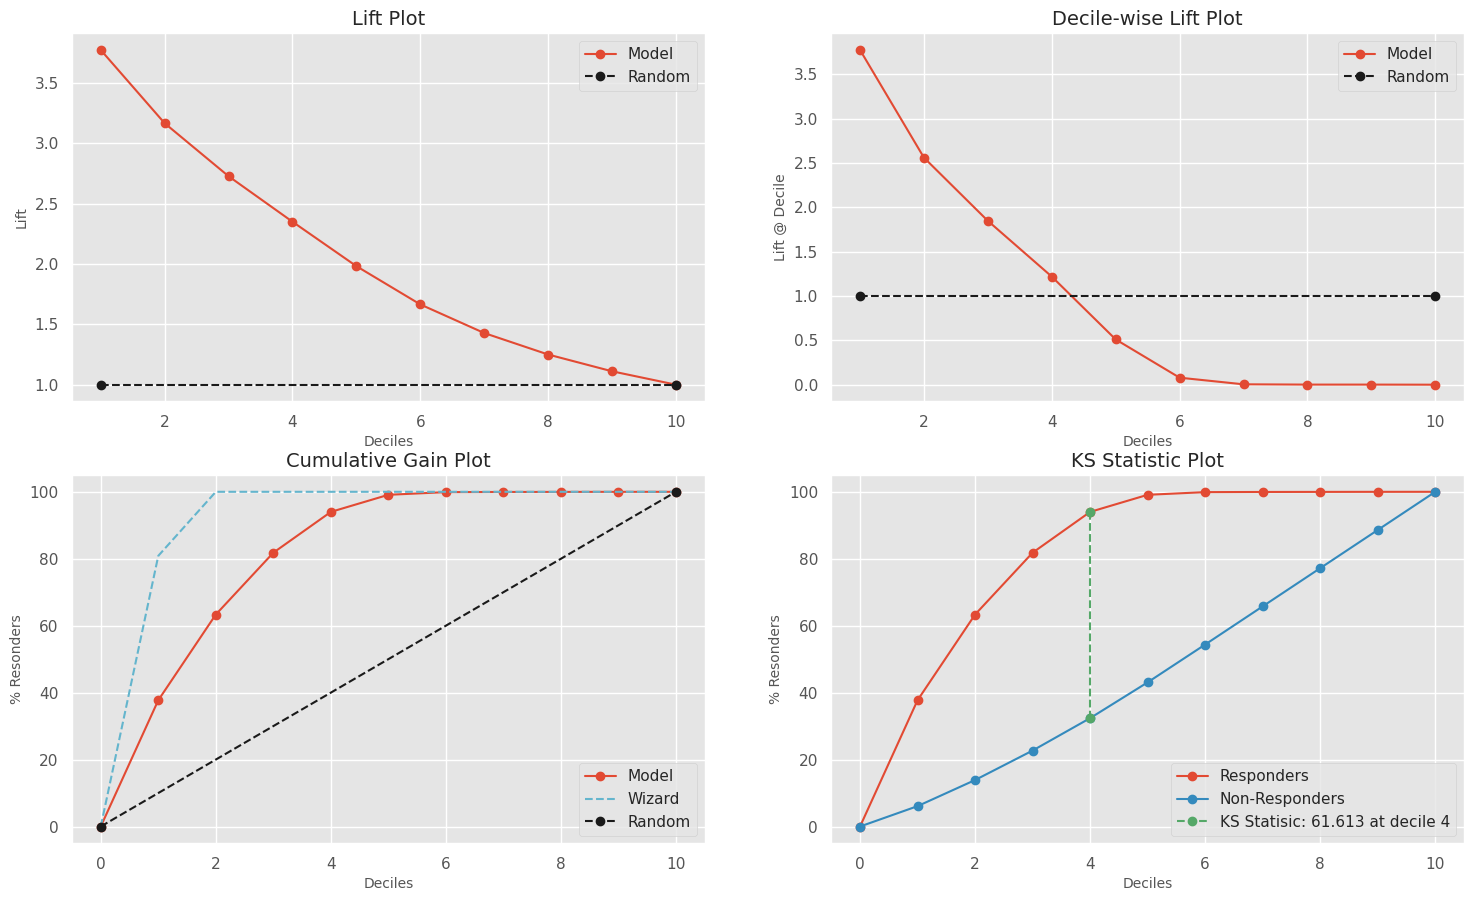

In [73]:
y_prob = opGBM.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

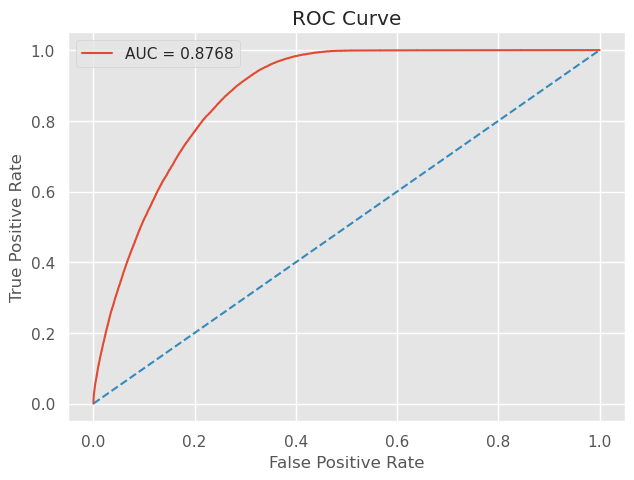

In [74]:
# Probabilidades predichas
y_prob_test = opGBM.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 6. Evaluación de Modelos


In [75]:
# Guardamos el mejor modelo entrenado para usarlo en la implementación
import pickle
filename = 'bestmodel.pkl'
pickle.dump(opGBM, open(filename, 'wb'))

# 7. Scoring del Modelo


In [76]:
# Todo lo realizado en el dataset de entrenamiento del modelo lo debemos replicar en el dataset de scoring

In [77]:
data_unseen.shape

(100000, 12)

In [78]:
data_unseen.head()

Gender  Age  Previously_Insured  Vehicle_Age  Vehicle_Damage  \
0       0   48                   1            1               0   
1       1   22                   0            0               1   
2       1   50                   0            1               1   
3       1   60                   1            1               1   
4       1   24                   0            0               1   

   Annual_Premium  Policy_Sales_Channel  Vintage  \
0           35124                    26       96   
1           26236                   152      102   
2           39641                    26      271   
3           30127                    26       79   
4           37644                   152      194   

   Previously_Insured_Annual_Premium  Previously_Insured_Vehicle_Damage  \
0                                  3                                  0   
1                                  9                                  1   
2                                 11                                  1   
3                                 19                                  2   
4                                 20                                  1   

   Previously_Insured_Vintage  Response  
0                           3         0  
1                           9         0  
2                          11         0  
3                          20         0  
4                          21         0

In [79]:
# Una vez que tenemos todas las variables podemos scorear o puntuar los registros

# Leemos el modelo entrenado!
import pickle
filename = 'bestmodel.pkl'
mod_seg = pickle.load(open(filename, 'rb'))

In [80]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
prob_final = mod_seg.predict_proba(data_unseen.drop(['Response'], axis=1))[:, 1]
pred_final = (prob_final >= best_threshold).astype(int)

In [81]:
pred_final.size

100000

In [82]:
# Construir DataFrame final
df_submit = pd.DataFrame({
    'Response': data_unseen['Response'],
    'Prob': prob_final,
    'Predicted': pred_final
})
# Exportamos la solucion
df_submit.to_csv('final_score.csv', index=False)